In [13]:
using LinearAlgebra
using Plots

function quadrotor_dynamics(state, inputs, dt)
    # Unpack the state
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    
    # Unpack the inputs
    thrust, tau_phi, tau_theta, tau_psi = inputs
    
    # Constants
    m = 1.0  # Mass of the quadrotor
    g = 9.81  # Gravitational acceleration
    Ix = 0.01  # Moment of inertia around x-axis
    Iy = 0.01  # Moment of inertia around y-axis
    Iz = 0.02  # Moment of inertia around z-axis
    
    # Translational dynamics
    ax = 0
    ay = 0
    az = thrust / m - g
    
    # Rotational dynamics
    p_dot = tau_phi / Ix
    q_dot = tau_theta / Iy
    r_dot = tau_psi / Iz
    
    # Integrate to get the new state
    new_state = [
        x + vx * dt,
        y + vy * dt,
        z + vz * dt,
        vx + ax * dt,
        vy + ay * dt,
        vz + az * dt,
        phi + p * dt,
        theta + q * dt,
        psi + r * dt,
        p + p_dot * dt,
        q + q_dot * dt,
        r + r_dot * dt
    ]
    
    return new_state
end

function linearize(state_eq, input_eq, dt)
    n_states = length(state_eq)
    n_inputs = length(input_eq)
    
    A = zeros(n_states, n_states)
    B = zeros(n_states, n_inputs)
    
    epsilon = 1e-6
    
    for i in 1:n_states
        delta = zeros(n_states)
        delta[i] = epsilon
        state_plus = state_eq + delta
        state_minus = state_eq - delta
        
        f_plus = quadrotor_dynamics(state_plus, input_eq, dt)
        f_minus = quadrotor_dynamics(state_minus, input_eq, dt)
        
        A[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    for i in 1:n_inputs
        delta = zeros(n_inputs)
        delta[i] = epsilon
        input_plus = input_eq + delta
        input_minus = input_eq - delta
        
        f_plus = quadrotor_dynamics(state_eq, input_plus, dt)
        f_minus = quadrotor_dynamics(state_eq, input_minus, dt)
        
        B[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    return A, B
end

function kalman_filter(A, B, C, D, Q, R, x_hat, P, u, y, W, w)
    x_hat_minus = A * x_hat + B * u + W * w
    P_minus = A * P * A' + Q
    
    K = P_minus * C' / (C * P_minus * C' + R)
    x_hat_plus = x_hat_minus + K * (y - C * x_hat_minus - D * u)
    P_plus = (I - K * C) * P_minus
    
    return x_hat_plus, P_plus
end

kalman_filter (generic function with 1 method)

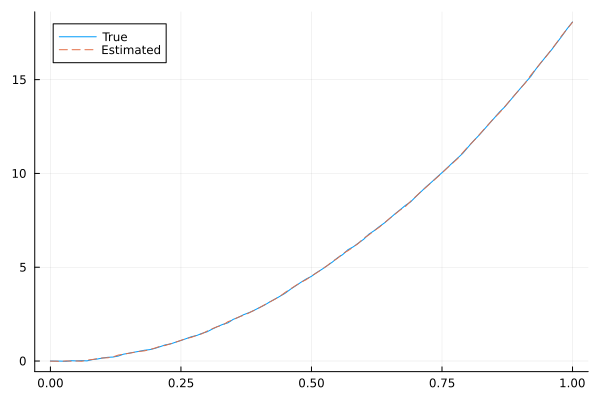

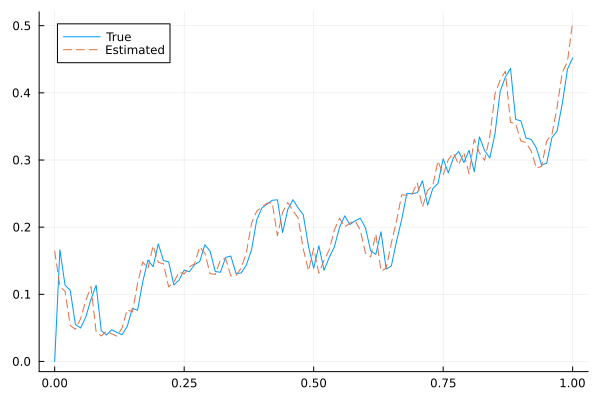

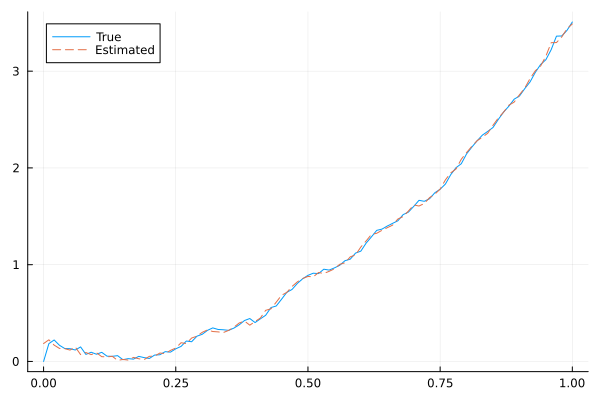

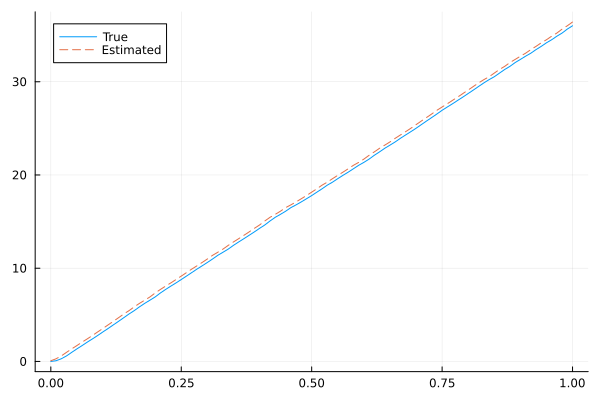

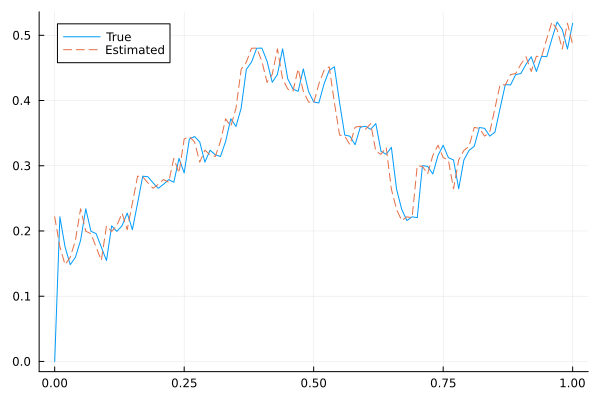

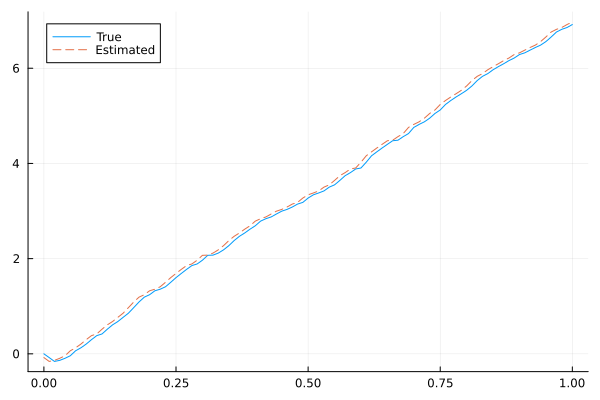

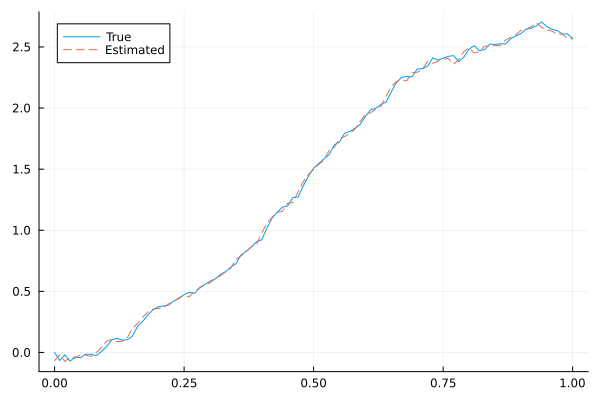

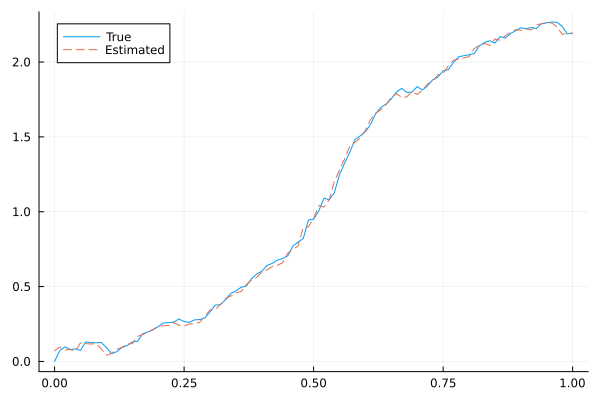

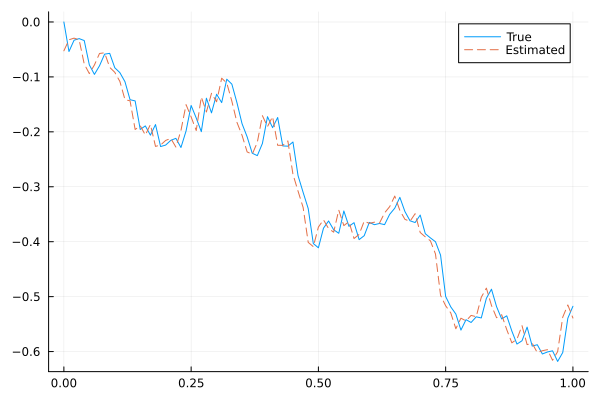

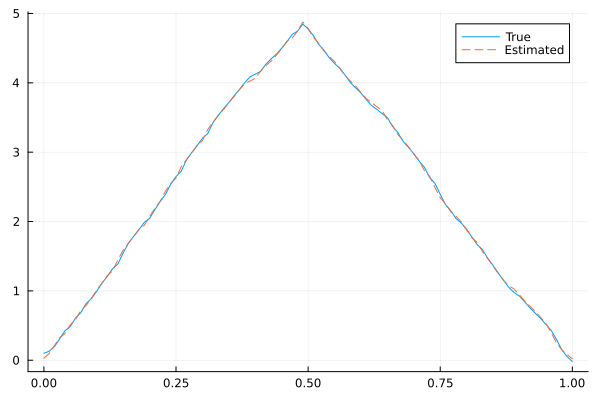

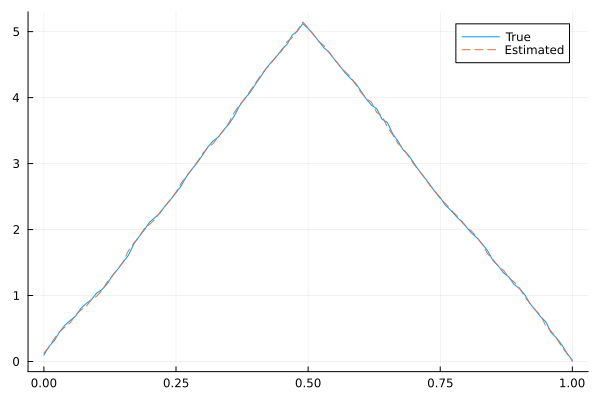

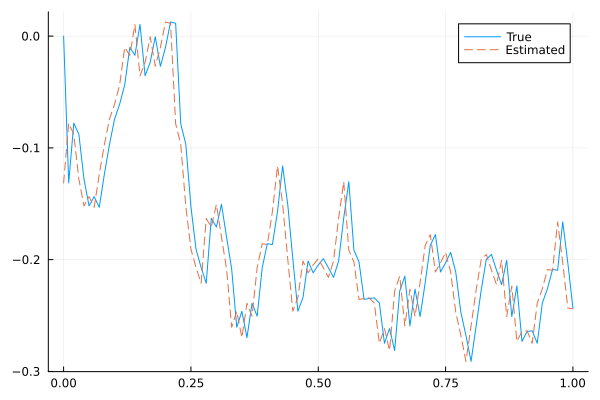

In [14]:
# Simulation parameters
dt = 0.01
time = 0:dt:1
n_states = 12
n_inputs = 4
state_eq = zeros(n_states)
input_eq = [9.81, 0, 0, 0]
Q = I * 0.01
R = I * 0.1
w1 = zeros(n_states, 3)
w1[4, 1] = 1  # Wind effect on vx
w1[5, 2] = 1  # Wind effect on vy
w1[6, 3] = 1  # Wind effect on vz
w2 = [0.5, 0, 0]

x_hat = zeros(n_states)
P = I(n_states)

true_states = []
estimated_states = []


# run simulation
for t in time
    # TODO replace this test case with controller inputs
    if t < 0.5
        inputs = [9.81, 0.1, 0.1, 0]
    else
        inputs = [9.81, -0.1, -0.1, 0]
    end
    
    true_state = quadrotor_dynamics(x_hat, inputs, dt)
    push!(true_states, true_state)
    
    measurements = true_state + randn(n_states) * 0.1
    
    A, B = linearize(x_hat, inputs, dt)
    
    C = I(n_states)
    D = zeros(n_states, n_inputs)
    
    x_hat, P = kalman_filter(A, B, C, D, Q, R, x_hat, P, inputs, measurements, w1, w2)
    
    push!(estimated_states, x_hat)
end

# Convert results to arrays for plotting
true_states = hcat(true_states...)
estimated_states = hcat(estimated_states...)

# Plotting
for i in 1:n_states
    p = plot(time, true_states[i, :], label="True")
    plot!(time, estimated_states[i, :], label="Estimated", linestyle=:dash)
    display(p)
end